In [ ]:
# Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import io
import tempfile
from kaggle import api

# Data Exploration & Preprocessing
We start with the train dataset

In [31]:
df = pd.read_csv('data/train_submission.csv')
print("Size of the dataset: ", len(df))
print("Number of labels: ", df['Label'].nunique() +1)
df.head()

Size of the dataset:  190599
Number of labels:  390


,Usage,Text,Label
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Public,Filmen forteller historien om Will Hunting en...,nob
2,Public,An Arthrostylidium berryi in uska species han ...,wln
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh


The dataset contains 190599 instances and 390 labels.

Let's now have a look on the distribution of the labels in the dataset.

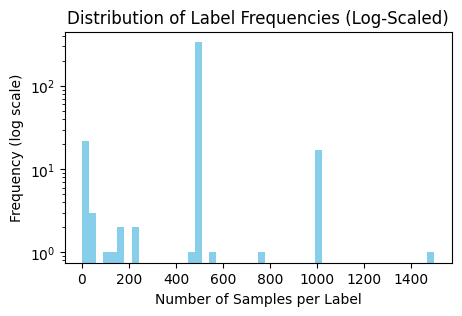

In [32]:
plt.figure(figsize=(5, 3))
plt.hist(df['Label'].value_counts(), bins=50, color='skyblue')
plt.yscale('log')
plt.xlabel('Number of Samples per Label')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Label Frequencies (Log-Scaled)')
plt.show()


The dataset is highly imbalanced.

To better understand its distribution, we can take a closer look at the class frequencies, to identify both the most and least represented categories. Given that there are 389 classes in total, we visualize the distribution of the 30 most frequent and 30 least frequent classes.

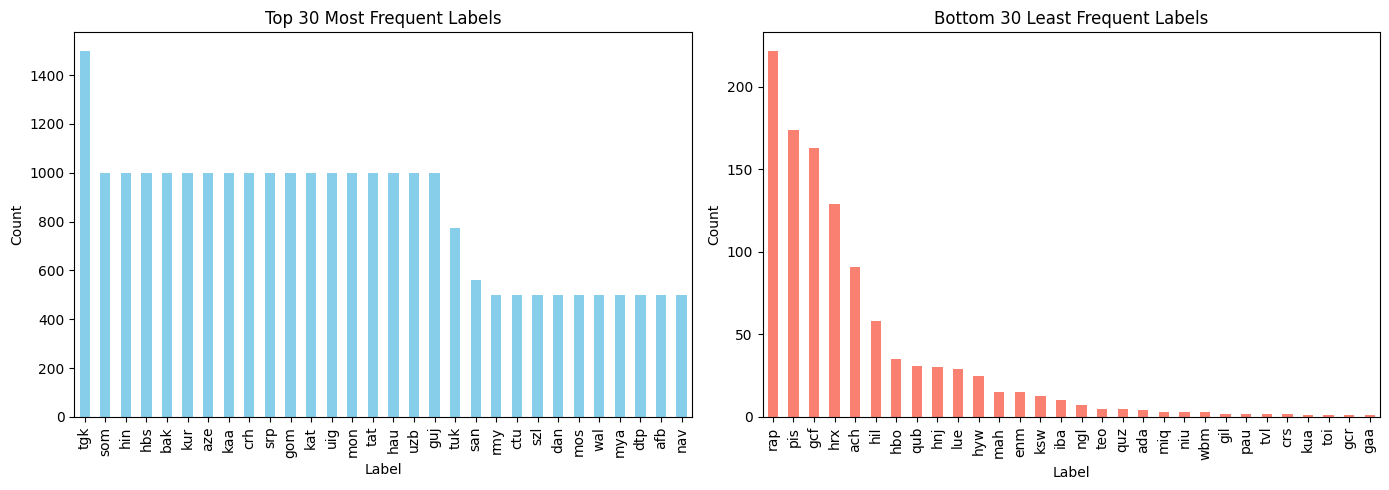

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

# Plot the top 30 labels 
df['Label'].value_counts().head(30).plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 30 Most Frequent Labels')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# Plot the bottom 30 labels 
df['Label'].value_counts().tail(30).plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Bottom 30 Least Frequent Labels')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


To better investigate this dataset, we drop the usage column as well as duplicated instances. We also look for potential missing labels.

In [34]:
df = df.drop(columns=['Usage'])
df = df.drop_duplicates()
# rows with nan values in the label column
df[df['Label'].isna()]

,Text,Label
107,Kòe bô jōa kú hō͘-sū sió-chiá lâi kā góan mn̄...,NaN
803,Söğütçük sī chi̍t ê tī Türkiye Aydın séng Çine...,NaN
1095,Golden Valley Kūn ū khó-lêng sī kóng:,NaN
1894,Tī Montégut-Lauragais ê sì-ûi ū Nogaret Revel...,NaN
2499,Soveria Simeri ùi séng lāi ê hoān-ûi.,NaN
...,...,...
189637,Bellebrune sī ūi-tī Hoat-kok Nord-Pas-de-Calai...,NaN
189946,Bô phah-sǹg tī sin-le̍k 10 go̍eh 29 hō ē-po͘ ...,NaN
189959,Wiejki sī chi̍t ê tī Pho-lân Kiōng-hô-kok Podl...,NaN
190397,Tī pún só͘-chāi sì-ûi ê tē-hng ū Valy Veselí ...,NaN


These texts are possibly written in Min Nan Chinese, which has the language code "nan".

As a result, their labels were mistakenly interpreted as NaN (null values).

One approach to address this issue is to explicitly convert these labels into the string 'nan'. However, since the final model evaluation is conducted on Kaggle, and the method used to read the evaluation CSV file likely does not distinguish between NaN (null values) and 'nan' (string), it is preferable to exclude this class from the training process altogether.

In [35]:
# drop rows that have Nan values in label
df = df.dropna(subset=['Label'])

To have a better accuracy when training, and as the test and train datasets have the same distributions, we choose to delete the least frequent classes.

In [36]:
#see how many classes have more than 15 samples
print("Number of classes with more than 15 occurences: ",df['Label'].value_counts()[df['Label'].value_counts()>15].shape)
df = df.groupby('Label').filter(lambda x: len(x) > 15)
print(df.isnull().sum())

Number of classes with more than 15 occurences:  (370,)
Text     0
Label    0
dtype: int64


In [37]:
df.to_csv('data/train_submission_preprocessed.csv', index=False)

Now let's preprocess quickly the test dataset to remove the column 'Usage'.

In [38]:
test = pd.read_csv('data/test_without_labels.csv')
test = test.drop(columns=['Usage'])
test.to_csv('data/test_without_labels_preprocessed.csv', index=False)

# Anomalies in train dataset...

At this step, we are sure that there are not duplicated in the train dataset instances however, the bellow cell shows some inconsistencies in the data. In fact, the same text is labeled differently in each time:

In [39]:
# see the lines 178069, 141957 and 64261 in the df
df.loc[[178069, 141957, 64261]]

,Text,Label
178069,Da Ort hod bei da Voikszejung 94,mwl
141957,Da Ort hod bei da Voikszejung 94,nso
64261,Da Ort hod bei da Voikszejung 94,hin


If we choose to keep only one instance of such anomalies, the number of rows will be reduced to 190561, down from 190599.

However, there are additional cases where identical texts appear multiple times in the training data but are assigned different labels. Since we cannot determine the correct label in these instances, we opt to remove all occurrences of such duplicated texts to ensure label consistency and improve data quality.

In [40]:
df = df.drop_duplicates(subset='Text')

Let's now further investigate the consistency of the train dataset.

In [ ]:
# see all 'hat' texts
hat_df =df[df['Label'] == 'hat']
print(hat_df.iloc[2]['Text'])
print(hat_df.iloc[-1]['Text'])
hat_df

1927 : Pour l'amour de Mike (For the Love of Mike) de Frank Capra : Mary
Publié par Masken à 22:46 Aucun commentaire:


,Text,Label
16,PIVX Swazi Lilangeni (SZL) 58.36709 L PIVX → SZL,hat
384,Harleigh PA Harlem PA Harleysville PA Harmo...,hat
633,1927 : Pour l'amour de Mike (For the Love of M...,hat
822,mwen kwè mwen pale de sa deja lan yon lòt pòs ...,hat
828,MP G16 SLIM PISTOL GRIP - DARK...,hat
...,...,...
188508,nme ak Fazrul...tp sume mmber ak pnggil ak Jer...,hat
189243,Ansyen minis transpò Soluk te vizite TÜDEMSAŞ,hat
190506,Ki jan ou fè jwenn DA a Pentax 55-300 konpare ...,hat
190543,Plan jigo dwat Vole postal devan ak fèmti bout...,hat


For the label 'hat', as well as many others, we found that the labeling was incorrect. Many texts, whose languages we can confidently identify, were misclassified.

Despite these inaccuracies, we chose to continue working with the same dataset—even though it contains a significant number of mislabeled entries—because our goal is to maximize the test accuracy score. After extensive investigations and analyses, we observed that the test data follows a similar distribution and also contains mislabeled instances.

-----
### Testing where Kaggle accepts 'nan' as a class label

To do so we create a new dataframe that has the same line numbers as test and that has 2 columns: ID and Label, the id from 1 to 190567 and the labels are all 'nan'. We must make sure that the label column is of type String.

In [ ]:
n = 190567

df3 = pd.DataFrame({
    'ID': range(1, n+1),
    'Label': ['nan'] * n
})
df3['Label'] = df3['Label'].astype(str)
df3.to_csv('submission.csv', index=False, quoting=csv.QUOTE_ALL, na_rep="nan")
df3.head()

,ID,Label
0,1,nan
1,2,nan
2,3,nan
3,4,nan
4,5,nan


In [ ]:
csv_buffer = io.StringIO()
df3.to_csv(csv_buffer, index=False)

with tempfile.NamedTemporaryFile(mode="w+", suffix=".csv", delete=False) as tmp:
    tmp.write(csv_buffer.getvalue())
    tmp_path = tmp.name  

# Submit the file using the Kaggle API
api.competition_submit(file_name=tmp_path, message="Submission from Notebook", competition="nlp-cs-2025")

100%|██████████| 1.89M/1.89M [00:01<00:00, 1.70MB/s]


Successfully submitted to NLP CS 2025

It’s not working 🙁. So, let's continue working with the training data while excluding the 'nan' label from the Min Nan Chinese language.